<a href="https://colab.research.google.com/github/albivaltzew/urbancode_samolet/blob/main/Masha_%22albumentations_coco_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
!pip install --upgrade albumentations

In [ ]:
pip install pycocotools


In [ ]:
pip install layoutparser


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.2/19.2 MB 28.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.5/47.5 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 44.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 47.1 MB/s eta 0:00:00
  Created wheel for iopath: filename=iopath-0.1.10-py3-none-any.whl size=31530 sha256=f6e09ec2d091dc2bfa4da75c7fe456599b9be3c080dd9c591cfa013895b1c9b7
  Stored in directory: /root/.cache/pip/wheels/9a/a3/b6/ac0fcd1b4ed5cfeb3db92e6a0e476cfd48ed0df92b91080c1d
Successfully built iopath


In [ ]:
import os
import cv2
import json
import albumentations as A
import numpy as np

from pycocotools.coco import COCO
import layoutparser as lp
import random


In [ ]:
def load_coco_annotations(annotations, coco=None):
    """
    Args:
        annotations (List):
            a list of coco annotaions for the current image
        coco (`optional`, defaults to `False`):
            COCO annotation object instance. If set, this function will
            convert the loaded annotation category ids to category names
            set in COCO.categories
    """
    layout = lp.Layout()

    for ele in annotations:

        x, y, w, h = ele['bbox']

        layout.append(
            lp.TextBlock(
                block = lp.Rectangle(x, y, w+x, h+y),
                type  = ele['category_id'] if coco is None else coco.cats[ele['category_id']]['name'],
                id = ele['id']
            )
        )

    return layout


In [ ]:

COCO_ANNO_PATH = '/content/gdrive/MyDrive/urbancode/urbanhack-train/annotations/instances_default.json'
COCO_IMG_PATH  = '/content/gdrive/MyDrive/urbancode/urbanhack-train/images'

coco = COCO(COCO_ANNO_PATH)

loading annotations into memory...
Done (t=0.82s)
creating index...
index created!


<ipython-input-10-87fcac8aee8b>:9: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  for image_id in random.sample(coco.imgs.keys(), 1):


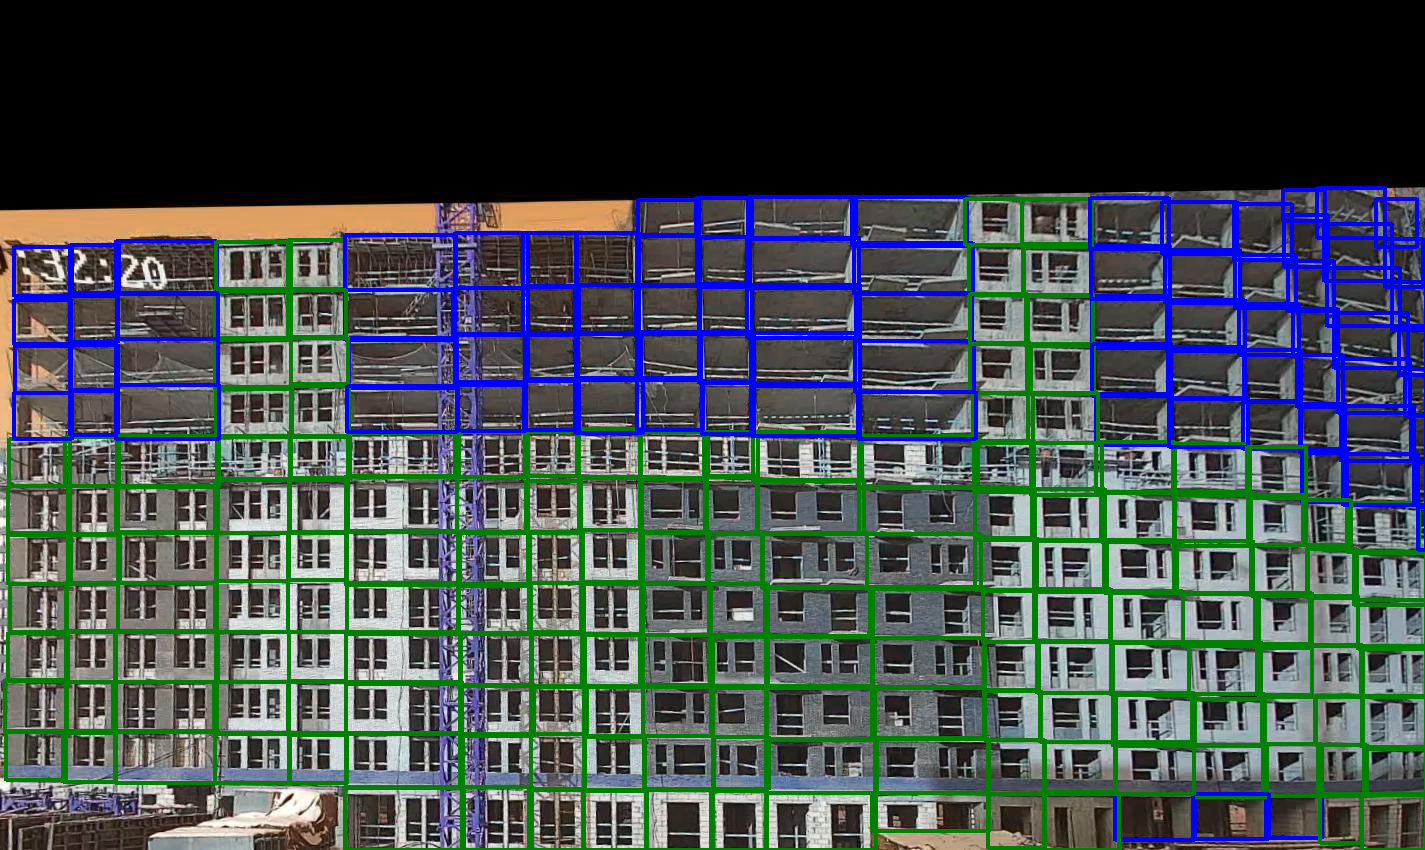

In [ ]:
color_map = {
    'window':   'red',
    'empty':  'blue',
    'filled':   'green',
}



for image_id in random.sample(coco.imgs.keys(), 1):
    image_info = coco.imgs[image_id]
    annotations = coco.loadAnns(coco.getAnnIds([image_id]))

    image = cv2.imread(f'{COCO_IMG_PATH}/{image_info["file_name"]}')
    layout = load_coco_annotations(annotations, coco)

    viz = lp.draw_box(image, layout, color_map=color_map)
    display(viz) # show the results

In [ ]:
augmented_images = []
augmented_annotations = []

In [ ]:
for image_info in images:

    image_path = os.path.join(image_folder, image_info['file_name'])

    print(image_path)
    image = cv2.imread(image_path)
    image = np.array(image)

    print(f"Loaded image: {image_info['file_name']}, shape: {image.shape}")  # Debugging

    augmented = augmentation(image=image)

    augmented_image = augmented['image']


    # Transform bounding box coordinates
    transformed_annotations = []
    for annotation in annotations:
        if annotation['image_id'] == image_info['id']:
            bbox = annotation['bbox']
            x, y, w, h = bbox

            # Apply augmentation to bounding box
            transformed_bbox = A.core.bbox_utils.normalize_bbox(
                [x, y, x + w, y + h], rows=image.shape[0], cols=image.shape[1]
            )
            transformed_bbox = A.core.bbox_utils.denormalize_bbox(
                transformed_bbox, rows=augmented_image.shape[0], cols=augmented_image.shape[1]
            )

            transformed_annotations.append({
                'id': annotation['id'],
                'image_id': image_info['id'],
                'category_id': annotation['category_id'],
                'bbox': transformed_bbox,
                'iscrowd': annotation['iscrowd'],
                'attributes': annotation['attributes'],  # You may need to adjust this if needed
            })

    augmented_images.append(augmented_image)
    augmented_annotations.extend(transformed_annotations)

In [ ]:
# Save the augmented dataset
augmented_coco_data = {
    'images': images,
    'annotations': augmented_annotations,
    'categories': coco_data['categories'],  # Ensure 'categories' is present in your original JSON
}

In [ ]:
augmented_path = "/content/gdrive/MyDrive/urbanhack-train/augmented_annotations.json"

In [ ]:
with open(augmented_path, 'w') as f:
    json.dump(augmented_coco_data, f)

In [ ]:
# Папка для сохранения аугментированных изображений
output_folder = '/content/gdrive/MyDrive/urbanhack-train/augmented_images'  # Замените на путь к папке, в которой хотите сохранить аугментированные изображения
os.makedirs(output_folder, exist_ok=True)

In [ ]:
for i, augmented_image in enumerate(augmented_images):
    # Генерируйте уникальное имя файла для каждого изображения
    output_filename = os.path.join(output_folder, f'augmented_image_{i}.jpg')

    # Сохраните аугментированное изображение
    cv2.imwrite(output_filename, augmented_image)

Подсчет количества файлов в папке

BBOXParams

Про методы:
https://hasty.ai/docs/mp-wiki/augmentations/interpolation-methods

Про погодные эффекты
https://albumentations.ai/docs/examples/example_weather_transforms/

In [ ]:
def get_augmentation_pipeline(category_ids):
    return A.Compose([
        A.HorizontalFlip(p=0.5),
        A.Rotate(limit=30, p=0.2),
        A.OneOf([
            A.RandomBrightnessContrast(p=0.5),
            A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, p=0.5), # изменение цвета
            A.augmentations.transforms.GaussNoise(var_limit=(10,50),mean=0,p=0.5), # шум гаусса
            A.augmentations.transforms.CLAHE (clip_limit=4.0, tile_grid_size=(8, 8), always_apply=False, p=0.5)
        ], p=0.3),
        A.Blur(blur_limit=3, p=0.1), # Размытие
        # A.augmentations.transforms.Equalize(),
        A.augmentations.geometric.transforms.Affine(p=0.1, shear={'x': (-30, 30), 'y': (-30, 30)}),
        A.OneOf([
            A.augmentations.transforms.ToGray(p=0.2), # оттенки серого
            A.RandomRain(brightness_coefficient=0.9, drop_width=1, blur_value=3, p=0.2), # добавляет дождь
            A.RandomSnow(brightness_coeff=2.5, snow_point_lower=0.3, snow_point_upper=0.5, p=0.2), #Добавляет снег
            A.RandomFog(fog_coef_lower=0.3, fog_coef_upper=0.6, alpha_coef=0.1, p=0.2), # туман
            A.RandomSunFlare(flare_roi=(0, 0, 1, 0.5), angle_lower=0.5, p=0.22), # солнечные блики
        ],p=0.3),
    ], bbox_params=A.BboxParams(format='coco', min_area=1024, min_visibility=0.3, label_fields=category_ids))


In [ ]:
# Create a new folder to save augmented images
output_image_folder = '/content/gdrive/MyDrive/urbancode/urbanhack-train/augmented_images'
os.makedirs(output_image_folder, exist_ok=True)


In [ ]:
categories = ["window", "empty", "filled"]

In [ ]:
# Initialize variables to track the augmented dataset
augmented_coco_data = {'images': [], 'annotations': [], 'categories': categories}


In [ ]:
# Define the number of augmented images per original image
num_augmented_images = 10

In [ ]:

COCO_ANNO_PATH = '/content/gdrive/MyDrive/urbancode/urbanhack-train/annotations/instances_default.json'
COCO_IMG_PATH  = '/content/gdrive/MyDrive/urbancode/urbanhack-train/images'

coco = COCO(COCO_ANNO_PATH)

loading annotations into memory...
Done (t=0.39s)
creating index...
index created!


In [ ]:
len(coco.imgs.keys())

252

In [ ]:
class_labels = ["window", "empty", "filled"]

In [ ]:
annotations_new  =[]

In [ ]:
# Perform augmentation and update annotations
for image_id in (coco.imgs.keys()):
    image_info = coco.imgs[image_id]
    annotations = coco.loadAnns(coco.getAnnIds([image_id]))

    image = cv2.imread(f'{COCO_IMG_PATH}/{image_info["file_name"]}')
    print(annotations)

    bboxes = []
    class_categories = []
    for i in range(len(annotations)):
          bboxes.append(annotations[i]["bbox"])
          class_categories.append(annotations[i]['category_id'])


    transform = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.Rotate(limit=30, p=0.2),
        A.OneOf([
            A.RandomBrightnessContrast(p=0.5),
            A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, p=0.5), # изменение цвета
            A.augmentations.transforms.GaussNoise(var_limit=(10,50),mean=0,p=0.5), # шум гаусса
            A.augmentations.transforms.CLAHE (clip_limit=4.0, tile_grid_size=(8, 8), always_apply=False, p=0.5)
        ], p=0.3),
        A.Blur(blur_limit=3, p=0.1), # Размытие
        # A.augmentations.transforms.Equalize(),
        A.augmentations.geometric.transforms.Affine(p=0.1, shear={'x': (-30, 30), 'y': (-30, 30)}),
        A.OneOf([
            A.augmentations.transforms.ToGray(p=0.2), # оттенки серого
            A.RandomRain(brightness_coefficient=0.9, drop_width=1, blur_value=3, p=0.2), # добавляет дождь
            A.RandomSnow(brightness_coeff=2.5, snow_point_lower=0.3, snow_point_upper=0.5, p=0.2), #Добавляет снег
            A.RandomFog(fog_coef_lower=0.3, fog_coef_upper=0.6, alpha_coef=0.1, p=0.2), # туман
            A.RandomSunFlare(flare_roi=(0, 0, 1, 0.5), angle_lower=0.5, p=0.22), # солнечные блики
        ],p=0.3),
    ], bbox_params=A.BboxParams(format='coco', min_area=1024, min_visibility=0.3, label_fields=['class_labels', 'class_categories']))

    print(class_labels)

    for _ in range(num_augmented_images):
        # augmentation_pipeline = get_augmentation_pipeline(category_ids = labels)

        augmented = transform(image=image, bboxes=bboxes, class_labels=class_labels, class_categories=class_categories)
        augmented_image = augmented['image']
        augmented_bboxes = augmented['bboxes']

        # Save augmented image
        output_image_path = os.path.join(output_image_folder, f"{image_info['file_name'][:-4]}_{np.random.randint(1, 1000)}.jpg")
        cv2.imwrite(output_image_path, augmented_image)


[{'id': 1, 'image_id': 1, 'category_id': 2, 'segmentation': [], 'area': 12677.091699999999, 'bbox': [98.87, 141.25, 110.63, 114.59], 'iscrowd': 0, 'attributes': {'occluded': False, 'rotation': 0.0}}, {'id': 2, 'image_id': 1, 'category_id': 2, 'segmentation': [], 'area': 16279.176900000006, 'bbox': [723.17, 184.07, 130.83, 124.43], 'iscrowd': 0, 'attributes': {'occluded': False, 'rotation': 0.0}}, {'id': 3, 'image_id': 1, 'category_id': 2, 'segmentation': [], 'area': 13944.253400000007, 'bbox': [475.7, 48.84, 116.62, 119.57], 'iscrowd': 0, 'attributes': {'occluded': False, 'rotation': 0.0}}, {'id': 4, 'image_id': 1, 'category_id': 2, 'segmentation': [], 'area': 13847.118300000011, 'bbox': [593.81, 62.38, 118.89, 116.47], 'iscrowd': 0, 'attributes': {'occluded': False, 'rotation': 0.0}}, {'id': 5, 'image_id': 1, 'category_id': 2, 'segmentation': [], 'area': 10862.957000000002, 'bbox': [0.0, 259.95, 81.34, 133.55], 'iscrowd': 0, 'attributes': {'occluded': False, 'rotation': 0.0}}, {'id': 

NameError: ignored